# Introduction to Inversions with HAZEL2 

Shuo Wang

Dept. of Astronomy, NMSU

DKIST Ambassador

[5th NCSP DKIST Data-Training Workshop: He I Diagnostics in the Solar Atmosphere](https://nso.edu/ncsp/ncsp-workshop/hei_diagnostics/)

In the presentation yesterday, we saw a graph with two directed edges representing synthesis and inversion. Together they form a **loop**. Let's implement the loop by doing the following steps:

1. Set a one-slab model. 
2. Do **synthesis** to generate the Stokes profiles.
3. Add noise to the Stokes profiles to simulate observations.
4. Do **inversion**.
5. Compare inversion results with the model.

The following code pieces together the code snippets explained in the previous presentations. Explanation of the code can be found in the [slides](http://astronomy.nmsu.edu/shuowang/dkistWorkshop5/).

## Synthesis

In [1]:
import hazel
import numpy as np
import h5py
import matplotlib.pyplot as plt

Set up model. LOS: $\theta, \phi, \gamma$.

In [2]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10828, 10831, 50], 'topology': 'ch1',
    'LOS': [0,0,90], 'Boundary condition': [1,0,0,0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 3, 
                          'Line': '10830', 'Wavelength': [10828, 10831]})
mod.setup()

Input: Bx, By, Bz, $\tau$, v, $\delta$v, $\beta$, a, ff.

In [3]:
mod.atmospheres['ch1'].set_parameters([-200, 50, 100, 1, -3, 6, 1, 0.5], 1)
mod.synthesize()

Plot spectral lines.

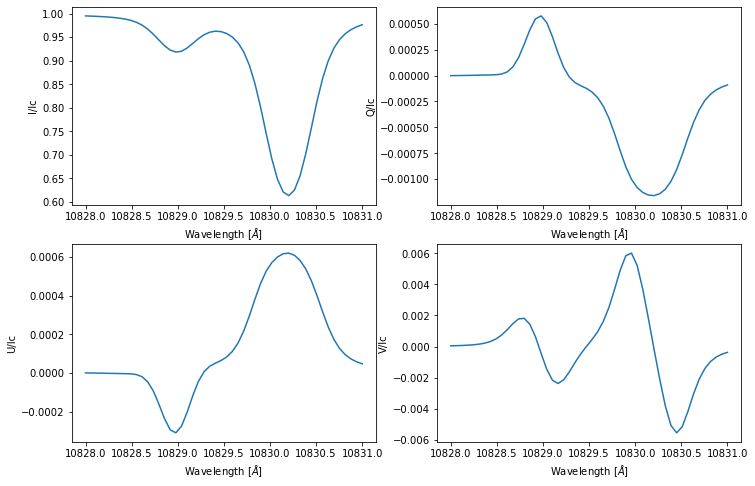

In [4]:
iq = 'IQUV'
ms = mod.spectrum['spec1']
plt.figure(figsize = (12,8))
for i in range(4):
    plt.subplot(221+i)
    plt.plot(ms.wavelength_axis, ms.stokes[i])
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel(iq[i]+'/Ic')

## Inversion

### Prepare input files:

**1. data file**

In [5]:
stokes = np.random.normal(loc=ms.stokes, scale=2e-4, size=ms.stokes.shape) # Add noise
noise = np.std(stokes[1,:5]) # noise can be different for all Stokes, all wavelength.
f = open('10830aStokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0 0 90\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1 0 0 0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,len(ms.wavelength_axis)))])
np.savetxt(f, tmp.T)
f.close()
%cat  -n 10830aStokes.1d

     1	# LOS theta_LOS, phi_LOS, gamma_LOS
     2	0 0 90
     3	
     4	# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
     5	1 0 0 0
     6	
     7	# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
     8	9.951139134810923492e-01 -2.592813120559787541e-04 1.285638322021800202e-04 9.791723865433432281e-05 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04
     9	9.950888991985374910e-01 -2.075548850146365391e-04 -3.957860218745476596e-04 1.135977167634817414e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04
    10	9.944203858392945961e-01 3.497735399562072961e-04 1.417965749555599915e-04 -2.124558781000705592e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.206649680713116714e-04
    11	9.934245110821399161e-01 -1.575839620669680142e-04 5.184656433215681804e-04 -2.872219167743991731e-04 2.206649680713116714e-04 2.206649680713116714e-04 2.20

**2. model file**

In [6]:
%cat -n model_chromosphere.1d

     1	 Bx    By   Bz   tau    v     deltav    beta    a     ff
     2	0   0   10.0   1.0   0.0     8.0      1.0    0.5    1


**3. configuration file**

In [7]:
%cat -n conf.ini

     1	# Hazel configuration File
     2	
     3	[Working mode]
     4	Output file = output.h5
     5	Number of cycles = 2
     6	
     7	# Topology
     8	# Always photosphere and then chromosphere
     9	# Photospheres are only allowed to be added with a filling factor
    10	# Atmospheres share a filling factor if they are in parenthesis
    11	# Atmospheres are one after the other with the -> operator
    12	# Atmosphere 1 = ph2 -> ch1 -> ch2
    13	
    14	[Spectral regions]
    15	    [[Region 1]]
    16	    Name = spec1
    17	    Wavelength = 10828, 10831, 50 ##
    18	    Topology = ch1
    19	    Observations file = '10830aStokes.1d'  
    20	    Weights Stokes I = 1, 0
    21	    Weights Stokes Q = 0, 1
    22	    Weights Stokes U = 0, 1
    23	    Weights Stokes V = 0, 1
    24	
    25	
    26	[Atmospheres]
    27	
    28	    [[Chromosphere 1]]
    29	    Name = ch1                                              # Name of the atmosphere component
    30	    Spectral region = 

### Invert

In [8]:
modi = hazel.Model('conf.ini', working_mode='inversion',verbose=1)
modi.read_observation()
modi.open_output()
modi.invert()
modi.write_output()
modi.close_output()

2022-01-26 11:25:30,954 - Hazel2 v1.0
2022-01-26 11:25:30,956 - Using configuration from file : conf.ini
2022-01-26 11:25:30,959 - Backtracking mode : brent
2022-01-26 11:25:30,960 - Adding spectral region spec1
2022-01-26 11:25:30,961 -   - Using wavelength axis from 10828.0 to 10831.0 with 50 steps
2022-01-26 11:25:30,963 -   - Setting all wavelength weights to 1
2022-01-26 11:25:30,964 -   - Using observations from 10830aStokes.1d
2022-01-26 11:25:30,965 -   - No mask for pixels
2022-01-26 11:25:30,965 -   - No instrumental profile
2022-01-26 11:25:30,967 -   - Using default boundary conditions [1,0,0,0] in spectral region spec1 or read from file. Check carefully!
2022-01-26 11:25:30,968 - Using 2 cycles
2022-01-26 11:25:30,969 - Using analytical RFs if possible : False
2022-01-26 11:25:30,970 - Using 10 max. iterations
2022-01-26 11:25:30,981 - Not using randomizations
2022-01-26 11:25:30,982 - Saving all cycles : False
2022-01-26 11:25:30,983 - Adding atmospheres
2022-01-26 11:25:

### Read results.

In [9]:
res = h5py.File('output.h5', 'r')  # explicitly close when no longer in use.
sto = ['Bx','By','Bz','tau','v','deltav','beta','a','ff']
stp = ''
for i in sto:
    sti = res['ch1'][i][0,0,0]
    stp += ', '+i+':'+f'{sti:.2f}'
chi2 = res['spec1']['chi2'][0,0,0]
print(stp[2:]+', chi2:'+f'{chi2:.2f}')

Bx:-199.58, By:53.06, Bz:100.03, tau:1.02, v:-3.01, deltav:6.13, beta:1.00, a:0.47, ff:1.00, chi2:0.61


Compare with input: 

[Bx, By, Bz, $\tau$, v, $\delta$v, $\beta$, a], ff

[-200, 50, 100, 1, -3, 6, 1, 0.5], 1)

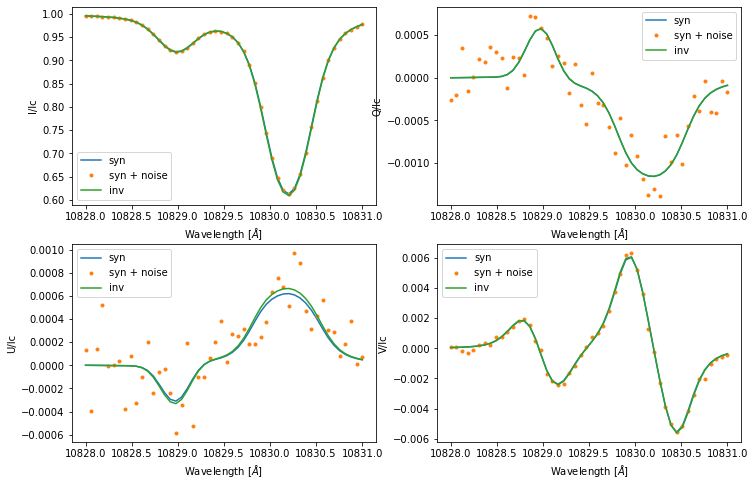

In [10]:
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(221+i)
    plt.plot(ms.wavelength_axis, ms.stokes[i],label='syn')
    plt.plot(ms.wavelength_axis, stokes[i],'.',label='syn + noise')
    plt.plot(ms.wavelength_axis, res['spec1']['stokes'][0,0,i],label='inv')
    plt.legend()
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel(iq[i]+'/Ic')
res.close() # close when no longer in use.